# Lab 9: Social Network Analysis

In this lab, we will explore a social network of legislators and the organizations that contribute to their campaigns.

The data is from [opensecrets.org](opensecrets.org), which collects public records about campaign finance in the United States.

We'll use `networkx`, a python package for social network analysis.

In [3]:
import pandas as pd
import networkx as nx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## The legislators

Information about each of the legislators (in the US Congress and Senate) is stored in `legislators.csv`. We'll use Pandas to read it into a dataframe.

In [5]:
df = pd.read_csv('legislators.csv',index_col=0)

## Exploring the legislators data frame

In [6]:
df.head(3)

,bioguide_id,birthdate,cid,comments,congress_office,exit_code,facebook_id,fax,feccandid,first_elected,...,gender,lastname,office,party,phone,twitter_id,votesmart_id,webform,website,youtube_url
0,L000578,1960-07-02,N00033987,NaN,322 Cannon House Office Building,0,RepLaMalfa,530-534-7800,H2CA02142,2012,...,M,LAMALFA,CA01,R,202-225-3076,RepLaMalfa,29713.0,https://lamalfa.house.gov/contact/email-me,http://lamalfa.house.gov,https://youtube.com/RepLaMalfa
1,H001068,1964-02-18,N00033030,NaN,1406 Longworth House Office Building,0,RepHuffman,202-225-5163,H2CA06259,2012,...,M,HUFFMAN,CA02,D,202-225-5161,RepHuffman,59849.0,https://huffman.house.gov/contact/email-me,http://huffman.house.gov,https://youtube.com/rephuffman
2,G000559,1945-01-24,N00030856,NaN,2438 Rayburn House Office Building,0,repgaramendi,202-225-5914,H0CA10149,2009,...,M,GARAMENDI,CA03,D,202-225-1880,RepGaramendi,29664.0,https://garamendi.house.gov/contact-me/email-me,http://garamendi.house.gov,https://youtube.com/garamendiCA10


Let's look at Atlanta's congressional representative, John Lewis.

In [7]:
df.loc[df['firstlast']=='John Lewis']

,bioguide_id,birthdate,cid,comments,congress_office,exit_code,facebook_id,fax,feccandid,first_elected,...,gender,lastname,office,party,phone,twitter_id,votesmart_id,webform,website,youtube_url
203,L000287,1940-02-21,N00002577,NaN,343 Cannon House Office Building,0,RepJohnLewis,202-225-0351,H6GA05217,1986,...,M,LEWIS,GA05,D,202-225-3801,RepJohnLewis,26820.0,https://johnlewis.house.gov/contact-me/email-m...,https://johnlewis.house.gov,https://youtube.com/repjohnlewis


To facilitate looking up legislators, here are some helper functions. The `cid` is a unique identifier per candidate.

In [9]:
get_leg_by_name = lambda name : df.loc[df['firstlast']==name]
get_leg_by_cid = lambda cid : df.loc[df['cid']==cid]

In [13]:
get_leg_by_name('John Lewis')

,bioguide_id,birthdate,cid,comments,congress_office,exit_code,facebook_id,fax,feccandid,first_elected,...,gender,lastname,office,party,phone,twitter_id,votesmart_id,webform,website,youtube_url
203,L000287,1940-02-21,N00002577,NaN,343 Cannon House Office Building,0,RepJohnLewis,202-225-0351,H6GA05217,1986,...,M,LEWIS,GA05,D,202-225-3801,RepJohnLewis,26820.0,https://johnlewis.house.gov/contact-me/email-m...,https://johnlewis.house.gov,https://youtube.com/repjohnlewis


**Your turn** Find the record of the youngest legislator in the data. (Hint: use the field `birthdate`.)

In [17]:
# your code here

## Exploring the social network

Now let's load in the social network between legislators and contributors. It's stored as an XML file; see the github repository for another notebook that shows how this data was acquired from opensecret's API.

In [4]:
G = nx.read_gexf('contributions.xml')

Let's look at some properties of the network. First we will check if it is **bipartite**. This means that the nodes can be divided into two sets, and all edges include exactly one node from each set. This should be true by construction, since each edge indicates one contributor and one legislator.

In [14]:
nx.is_bipartite(G)

True

Now let's check if the network is connected (remember what this means from class and the readings?)

In [15]:
nx.is_connected(G)

False

The fact that the network is not connected means that there are pairs of nodes between whom there is no path. Let's see if it is nearly connected.

In [114]:
print('Number of nodes: %d'%len(G.nodes()))
print('Largest component: %d'%len(max(nx.connected_components(G))))

Number of nodes: 971
Largest component: 954


Although the network isn't connected, 954 of the nodes are in the single largest component. 
This indicates that there is a path between nearly every pair of nodes in the network.

Now let's compute the **transitivity**. This is the fraction of triads $(a,b,c)$ which are connected but are not **cliques**: edges $(a,b)$ and $(b,c)$ exist, but $(a,c)$ does not exist.

In [16]:
nx.transitivity(G)

0

**Discuss**: Make sure you understand why the transitivity must be zero in a bipartite graph.

## Neighbors

It will be helpful to differentiate all nodes that are legislators and nodes that are contributors.

In [43]:
leg_nodes = [node for node in G.nodes() if node in list(df['cid'])]
contrib_nodes = G.nodes() - leg_nodes

In [44]:
print(len(leg_nodes),len(contrib_nodes),len(G.nodes()))

537 1876 2413


### Finding contributors to a specific candidate

Let's look at the donors to Georgia Senator David Perdue.

The legislators are nodes in the network, and are indexed by the `cid`, which is a unique identifier.

In [45]:
get_leg_by_name('David Perdue')['cid']

213    N00035516
Name: cid, dtype: object

We can find the neighbors using `nx.neighbors`

In [50]:
nx.neighbors(G,'N00035516')

In [58]:
print([_ for _ in nx.neighbors(G,'N00035516')])

["Wendy's Co", 'Delta Air Lines', 'AFLAC Inc', 'Southern Co', 'Koch Industries', 'KPMG LLP', 'Club for Growth', 'Cox Enterprises', 'Home Depot', 'Southeastern Minerals']


Unfortunately, Pandas makes the `cid` a weird structured object, so we have to call `.values[0]` to get the actual string. Let's just write another function.

In [48]:
leg_attr = lambda leg, attr : leg[attr].values[0]

# might break if two legislators have the same name
name_to_cid = lambda name : leg_attr(get_leg_by_name(name),'cid')

cid_to_name = lambda cid : leg_attr(get_leg_by_cid(cid),'firstlast')

In [59]:
print(name_to_cid('David Perdue'))
print(cid_to_name(name_to_cid('David Perdue')))
print([_ for _ in nx.neighbors(G,name_to_cid("David Perdue"))])

N00035516
David Perdue
["Wendy's Co", 'Delta Air Lines', 'AFLAC Inc', 'Southern Co', 'Koch Industries', 'KPMG LLP', 'Club for Growth', 'Cox Enterprises', 'Home Depot', 'Southeastern Minerals']


Let's see who else got donations from Delta Air Lines

In [33]:
print([_ for _ in nx.neighbors(G,'Delta Air Lines')])
print([cid_to_name(cid) for cid in nx.neighbors(G,'Delta Air Lines')])

['N00007781', 'N00031412', 'N00030980', 'N00032243', 'N00002593', 'N00028958', 'N00035516', 'N00029391', 'N00027500']
['Peter DeFazio', 'Mick Mulvaney', 'Kelly Ayotte', 'Jody B Hice', 'Johnny Isakson', 'Jason Chaffetz', 'David Perdue', 'Erik Paulsen', 'Amy Klobuchar']


Let's see what political party each of these legislators is from.

In [39]:
print([leg_attr(get_leg_by_cid(cid),
                'party')
       for cid in nx.neighbors(G,'Delta Air Lines')])

['D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']


**Your turn**: Find out what state each of these legislators is from. 

To do this, use the `office` attribute. The first two characters of the `office` indicate the state. If the second two characters are digits, then they indicate a district in the house of representatives; if second two characters are 'S1' or 'S2' then the legislator is a senator.

In [ ]:
# your code here

## Degree distributions

The degree of a node is the number of neighbors that the node has in the graph.

By construction, we can see only the top 10 contributors to each legislator. So their degree should always be 10. But for the contributors, there should be more diversity.

You can compute the degree for any node by calling `nx.degree(G,node)`

In [60]:
nx.degree(G,'Facebook Inc')

5

Which contributor donates to the most legislators?

In [62]:
# dictionary of contributors and their degrees
degrees = {contrib:nx.degree(G,contrib) for contrib in contrib_nodes}

# useful code for getting the key in a dict with the maximum value
max(degrees,key=degrees.get)

'Blue Cross/Blue Shield'

In [63]:
nx.degree(G,'Blue Cross/Blue Shield')

90

Let's plot a degree distribution

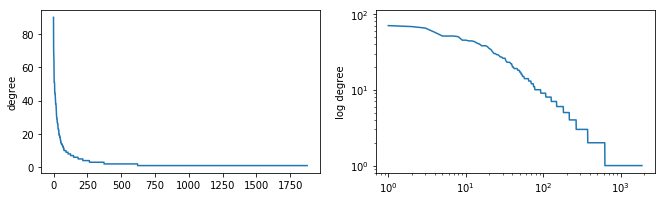

In [65]:
fig,ax=plt.subplots(1,2,figsize=[11,3])
ax[0].plot(sorted(degrees.values(),reverse=True))
ax[0].set_ylabel('degree')
ax[1].loglog(sorted(degrees.values(),reverse=True))
ax[1].set_ylabel('log degree');

The log-log plot is nearly linear, after the top 10 or 12 contributors. This means that this part of the distribution is approximated by a **power law**. We have observed a similar distribution over the frequencies of words. When a network's degree distribution follows a power law, the network is said to be [scale-free](https://en.wikipedia.org/wiki/Scale-free_network).

Scale-free networks can arise from a generative process featuring [preferential attachment](https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model): as new nodes are added to the graph, their likelihood of linking to some existing node is proportional to the degree of that node. 

**Discuss**: Do you think preferential attachment (PA) describes the process by which campaign contributions are made to legislators? What are some possible mechanisms that are consistent with PA? Why might contributors *not* behave according to PA?

## Betweenness

As described at the end of chapter 3 of the reading from [Networks Crowds and Markets](https://www.cs.cornell.edu/home/kleinber/networks-book/networks-book-ch03.pdf), the quantity of **betweenness** measures the extent to which a given edge can partition the graph. Betweenness centrality is the fraction of shortest paths on which each node sits.

In [66]:
# this takes a little while
btw_centrality = nx.bipartite.centrality.betweenness_centrality(G,leg_nodes)

In [67]:
sorted_btw = sorted(btw_centrality, key=btw_centrality.get,reverse=True)
top_contribs = [node for node in sorted_btw if node in contrib_nodes]
print([node for node in top_contribs[:10]])

['Blue Cross/Blue Shield', 'AT&T Inc', 'Boeing Co', 'American Crystal Sugar', 'National Assn of Realtors', 'American Bankers Assn', 'Berkshire Hathaway', 'Comcast Corp', 'Votesane PAC', 'JStreetPAC']


Blue Cross/Blue Shield has the highest degree, and is also the most central. Let's compare degrees and betweenness centrality.

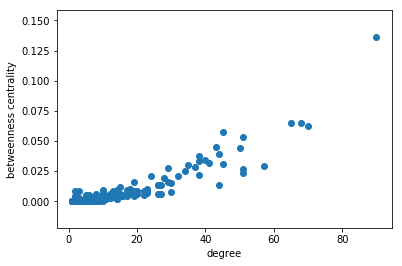

In [75]:
plt.scatter([G.degree(node) for node in sorted(list(contrib_nodes))],
         [btw_centrality[node] for node in sorted(list(contrib_nodes))])
plt.xlabel('degree')
plt.ylabel('betweenness centrality');

Another perspective on betweenness is that high-betweenness nodes might be more likely to donate to legislators of both parties, since presumably there are fewer paths across party lines. (This suggests *assortativity*, which we will discuss in detail next week.)

In [88]:
# percent of recipients who are democrats
contrib = 'Blue Cross/Blue Shield'
[leg_attr(get_leg_by_cid(cid),'party') 
 for cid 
 in G.neighbors(contrib)].count('D')/nx.degree(G,contrib)

0.32222222222222224

Now let's apply this code to all "big" contributors, with degree of 20 or more.

In [92]:
big_contribs = [node for node in contrib_nodes if nx.degree(G,node)>=20]

In [93]:
pct_dem = [[leg_attr(get_leg_by_cid(cid),'party') 
            for cid 
            in G.neighbors(contrib)].count('D')/nx.degree(G,contrib)
           for contrib
           in big_contribs]

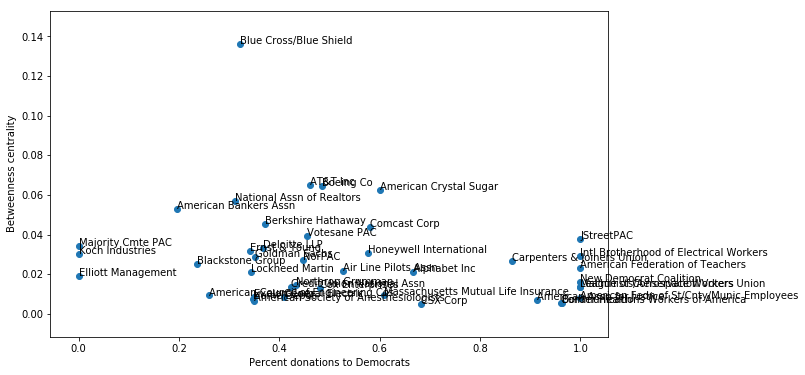

In [94]:
plt.figure(figsize=[10,6])
plt.scatter(pct_dem,[btw_centrality[contrib] for contrib in big_contribs])
for i,contrib in enumerate(big_contribs):
    plt.text(pct_dem[i],btw_centrality[contrib],contrib)
plt.xlabel('Percent donations to Democrats')
plt.ylabel('Betweenness centrality');

**Your turn**: Redo the plot of degree versus betweenness centrality, using color and/or shape to differentiate:

- Contributors who give at least 90% of their donations to Republicans
- Contributors who give at least 90% of their donations to Democrats
- All other contributors

## Projection

The legislator-contributor network is an example of an **affiliation network**. 

We can **project** across either set of nodes, inducing a network of legislators who share donors, or a network of contributors who donate to the same legislators. Let's now briefly investigate the projected legislator network.

In [98]:
?nx.projected_graph

In [97]:
G_leg = nx.projected_graph(G,leg_nodes)

Let's plot the degree distribution of this graph

In [103]:
degrees = {leg:nx.degree(G_leg,leg) for leg in leg_nodes}

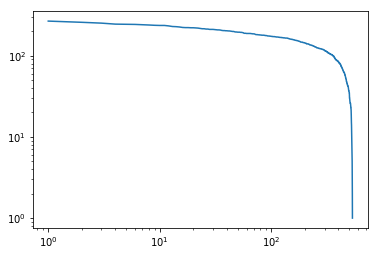

In [110]:
plt.loglog(sorted(degrees.values(),reverse=True));

Almost all nodes here have degree > 100, making the graph a little difficult to investigate. Let's look at the Georgia subgraph.

In [114]:
GA_legs = [leg for leg in leg_nodes if leg_attr(get_leg_by_cid(leg),'office')[:2]=='GA']
print(GA_legs)

['N00033518', 'N00002674', 'N00032416', 'N00027848', 'N00033720', 'N00035516', 'N00035347', 'N00030788', 'N00026163', 'N00002593', 'N00032243', 'N00002577', 'N00032457', 'N00026160', 'N00035346', 'N00024871']


In [115]:
G_ga = G_leg.subgraph(GA_legs)

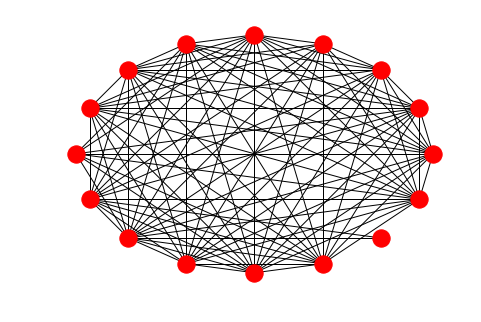

In [116]:
nx.draw_circular(G_ga)

The graph looks to be almost a clique.

In [122]:
print(len(G_ga.edges))
print(len(G_ga.nodes))

97
16


**Your turn**: compute the number of missing edges

In [123]:
# your code here

Just for fun, here's another layout.

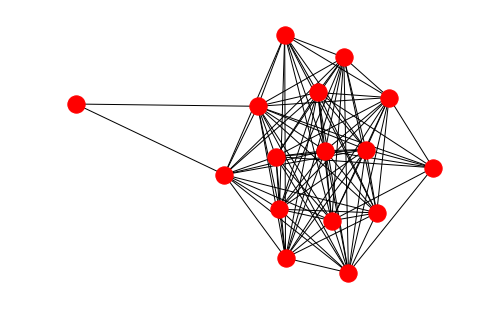

In [118]:
nx.draw_spring(G_ga)

## Homophily

**Ignore below here**

The property of homophily is that individuals with similar properties tend to be connected.


In [133]:
parties = {row['cid']:row['party'] for _,row in df.iterrows()}

In [137]:
nx.set_node_attributes(G,name='party',values=parties)

In [139]:
G_proj = nx.projected_graph(G,leg_nodes)

**Todo**: say more about this, plot Georgia subgraph.

In [142]:
nx.attribute_mixing_dict(G_proj,'party')

{'D': {'D': 3144, 'R': 1320}, 'R': {'D': 1320, 'R': 1492}}

This says: 

- 3144 links are between two democrats
- 1492 links are between two republicans
- 1320 links are between a democrat and a republican

What is the probability of a mixing matrix like this arising by chance? We'll come back to this later.

In [160]:
#here's another view
M_party = nx.attribute_mixing_matrix(G_proj,'party')
print(M_party)

[[ 0.20505772  0.18141836]
 [ 0.18141836  0.43210555]]


The trace of this matrix is the fraction of edges with the same value of the attribute.

In [161]:
M_party.trace()

0.63716327652556348

**Your turn:** compute the same matrix for the state from which each legislators is from. The state is identified by the first two characters of the `office` attribute.

In [202]:
# hide
states = {row['cid']:row['office'][:2] for _,row in df.iterrows()}
nx.set_node_attributes(G,name='state',values=states)
G_proj = nx.projected_graph(G,leg_nodes)
M_states = nx.attribute_mixing_matrix(G_proj,'state')
print(M_states.trace())

0.241616272677


The base probability of two nodes having the same attribute is $\theta = \sum_i P(i)^2$, summing over all possible values of the attribute. 

Under the null hypothesis, the trace of the attribute mixing matrix is drawn from a binomial distribution with parameters $(\theta, N)$, where $N$ is the total number of edges. Using this, we can compute $p$-values for these assortativity statistics.

In [159]:
from scipy.stats import binom

In [164]:
M_party_counts = M_party * len(G_proj.edges())

In [167]:
M_party_counts.trace()

2318.0

In [175]:
from collections import Counter

In [178]:
party_counts = Counter(parties.values())
party_counts

Counter({'D': 234, 'I': 1, 'R': 304})

In [183]:
p_party = np.array(list(party_counts.values()))/sum(party_counts.values())

In [184]:
p_party 

array([ 0.56400742,  0.43413729,  0.00185529])

In [189]:
p_agree = (p_party **2).sum()
p_agree

0.50658300088461761

In [196]:
1-binom.cdf(M_party_counts.trace(),len(G_proj.edges()),p_agree)

1.1102230246251565e-16

This very small $p$-value means that indeed, contributors tend to be shared across members of the same party.

**Your turn**: compute the same $p$-value for states

In [211]:
# hide
state_counts = Counter(states.values())
p_state = np.array(list(state_counts.values()))/sum(state_counts.values())
print((p_state**2).sum())
print(M_states.trace())
print(1-binom.cdf(M_states.trace()*len(G_proj.edges()),len(G_proj.edges()),(p_state**2).sum()))

0.0359939556865
0.241616272677
1.11022302463e-16
